In [1]:
import sys
# sys.path.append("/home/federico/programming/CM/")
sys.path.append("/home/federico/Desktop/University/CM/")

In [2]:
from src.LS.LS import LS
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import random
import sys
import time
import matplotlib.pyplot as plt

from src.NN.utils import *
from src.NN.metrics import mean_squared_error

from datetime import datetime as dt
import time

In [3]:
random.seed(42) # Needed for reproducibility

In [4]:
def scaling (starting_m, m, n, step, t, save=True) :
    """Tests the QR factorization for different matrices with m in [200, 5000] and n=50.
    Executes each example for a given amount of time and averages the times accordingly. For each result
    prints the size m and the average execution time, together with the time difference from the previous
    result.

    At the end of the process, saves an image showing the evolution of execution times over the increase
    of dimension m. The resulting image is saved in the resource folder as 'QRscaling_n50.png'.
    """

    print(f"n={n}, m={m}, t={t}")
    print(f"m{'':7} QR A3{'':<5s} delta{'':<5s} QR np{'':<5s} delta{'':<5s} LS A3{'':<5s} delta{'':<5s} LS np{'':<5s} delta{'':<5s}")
    print("----------------------------------------------------------------------------------------------------")
    
    ls_scaling = f"\nm{'':7} residual A3{'':<13s} residual np{'':<13s} reconstruct a3{'':<10s} reconstruct np{'':<10s}\n"\
                     f"----------------------------------------------------------------------------------------------------\n"
    
    stats = ""
    
    time_qr_a3 = []
    time_qr_np = []
    time_ls_a3 = []
    time_ls_np = []
    
    prev_qr_a3 = 0
    prev_qr_np = 0
    prev_ls_a3 = 0
    prev_ls_np = 0
    
    ls = LS()
    mrange = range(starting_m,m,step)
    for m in mrange:
        
        A,b = generate(m,n)
        mean_qr_a3 = 0
        mean_qr_np = 0
        mean_ls_a3 = 0
        mean_ls_np = 0
        
        for i in range(t):
            startQR = dt.now()
            R = ls.qr(A)
            Q = ls.revertQ()
            QR = np.matmul(Q, R)
            endQR = end_time(startQR)
            endQR = endQR.seconds*1000 + endQR.microseconds/1000
            mean_qr_a3 += endQR

            startQRnp = dt.now()
            Qnp, Rnp = np.linalg.qr(A)
            QRnp = np.matmul(Qnp, Rnp)
            endQRnp = end_time(startQRnp)
            endQRnp = endQRnp.seconds*1000 + endQRnp.microseconds/1000
            mean_qr_np += endQRnp
            
            # Computes time for LS solver 
            startLS = dt.now()
            res = ls.solve(A,b)
            endLS = end_time(startLS)
            endLS = endLS.seconds*1000 + endLS.microseconds/1000
            mean_ls_a3 += endLS
            
            # Computes time for LS solver using numpy
            startLSnp = dt.now()
            resnp, _, _, _ = np.linalg.lstsq(A,b,rcond=-1)
            endLSnp = end_time(startLSnp)
            endLSnp = endLSnp.seconds*1000 + endLSnp.microseconds/1000
            mean_ls_np += endLSnp
        
        mean_qr_a3 = (mean_qr_a3 / t)
        mean_qr_np = (mean_qr_np / t)
        mean_ls_a3 = (mean_ls_a3 / t)
        mean_ls_np = (mean_ls_np / t)
        
        delta_qr_a3 = mean_qr_a3 - prev_qr_a3
        delta_qr_np = mean_qr_np - prev_qr_np
        delta_ls_a3 = mean_ls_a3 - prev_ls_a3
        delta_ls_np = mean_ls_np - prev_ls_np
        
        time_qr_a3.append(mean_qr_a3)
        time_qr_np.append(mean_qr_np)
        time_ls_a3.append(mean_ls_a3)
        time_ls_np.append(mean_ls_np)
        
        prev_qr_a3 = mean_qr_a3
        prev_qr_np = mean_qr_np
        prev_ls_a3 = mean_ls_a3
        prev_ls_np = mean_ls_np
        
        
        residual_a3 = np.linalg.norm( b - np.dot(A, res) )/np.linalg.norm(b)
        residual_np = np.linalg.norm( b - np.dot(A, resnp) )/np.linalg.norm(b)
        reconstruct_a3 = np.linalg.norm( A - QR )/np.linalg.norm(A)
        reconstruct_np = np.linalg.norm( A - QRnp )/np.linalg.norm(A)
        
        stats += (f"Solved (m x n): ({m},{n}) in {mean_ls_a3} msec, w/ np in {mean_ls_np} msec"\
        f"- Reverting and reconstruction: {mean_qr_a3} msec, w/ np took: {mean_qr_np} msec\n"\
        f"res error: {residual_a3} "\
        f"- np_res error: {residual_np}\n"\
        f"QR error: {reconstruct_a3} "\
        f"- QR error w/ np: {reconstruct_np}\n\n")
        
        print(f"{m:<6} || {mean_qr_a3:8.4f} | {delta_qr_a3:8.4f} | {mean_qr_np:8.4f} | {delta_qr_np:8.4f} "\
             f"| {mean_ls_a3:8.4f} | {delta_ls_a3:8.4f} | {mean_ls_np:8.4f} | {delta_ls_np:8.4f}")
        
        ls_scaling += f"{m:<6} || {residual_a3:22} | {residual_np:22} | {reconstruct_a3:22} | {reconstruct_np:22}\n"
        
    print(ls_scaling)
    print(stats)
    
    # TODO: splittare i plotting mettendo nei return i range e le y da plottare
    
    # --- Plotting QR stats ---
    plt.plot(mrange, time_qr_np, "^-", label="np")
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"QR factorizzation of a matrix {m}x{n} (NP)")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/QRscaling_np_n{n}m{m}.png")
    else: plt.show()
    plt.clf()

    plt.plot (mrange, time_qr_a3, "o-", label="mio")
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"QR factorizzation of a matrix {m}x{n} (A3)")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/QRscaling_a3_n{n}m{m}.png")
    else: plt.show()
    plt.clf()
    
    plt.plot(mrange, time_qr_np, "^-", label="np")
    plt.plot (mrange, time_qr_a3, "o-", label="(A3)")
    plt.legend()
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"QR factorizzation of a matrix {m}x{n}")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/QRscaling_comparison_n{n}m{m}.png")
    else: plt.show()
    plt.clf()
    
    
    # --- Plotting LS stats ---
    plt.plot(mrange, time_ls_np, "^-")
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"LS of a matrix {m}x{n} (NP)")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/LSscaling_np_n{n}m{m}.png")
    else: plt.show()
    plt.clf()

    plt.plot (mrange, time_ls_a3, "o-")
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"LS of a matrix {m}x{n} (A3)")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/LSscaling_a3_n{n}m{m}.png")
    else: plt.show()
    plt.clf()
    
    plt.plot(mrange, time_qr_np, "^-", label="np")
    plt.plot (mrange, time_qr_a3, "o-", label="(A3)")
    plt.legend()
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"LS of a matrix {m}x{n}")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/LSscaling_comparison_n{n}m{m}.png")
    else: plt.show()
    plt.clf()
    

def automatized_test(M, b, test_type):
    ls = LS()
    m = M.shape[0]
    n = M.shape[1]

    # Computes time for LS solver 
    startLS = dt.now()
    res = ls.solve(M,b)
    endLS = end_time(startLS)
    endLS = endLS.seconds*1000 + endLS.microseconds/1000

    # Computes time for Q and QR reconstruction
    startQR = dt.now()
    R = ls.qr(M)
    Q = ls.revertQ()
    QR = np.matmul(Q, R)
    endQR = end_time(startQR)
    endQR = endQR.seconds*1000 + endQR.microseconds/1000

    # Computes QR factorization using numpy
    startQRnp = dt.now()
    Qnp, Rnp = np.linalg.qr(M)
    QRnp = np.matmul(Qnp, Rnp)
    endQRnp = end_time(startQRnp)
    endQRnp = endQRnp.seconds*1000 + endQRnp.microseconds/1000

    # Computes time for LS solver using numpy
    startLSnp = dt.now()
    resnp, _, _, _ = np.linalg.lstsq(M,b,rcond=-1)
    endLSnp = end_time(startLSnp)
    endLSnp = endLSnp.seconds*1000 + endLSnp.microseconds/1000

    print(f"---------- {test_type} DATASET ----------")
    print(f"Solved (m x n): ({m},{n}) in {endLS} msec, w/ np in {endLSnp} msec \
    - Reverting and reconstruction: {endQR} msec, w/ np took: {endQRnp} msec")
    print(f"res error: {np.linalg.norm( b - M@res )/np.linalg.norm(b)} "\
    f"- np_res error: {np.linalg.norm( b - np.matmul(M, resnp) )/np.linalg.norm(b)}")
    print(f"QR error: {np.linalg.norm( M - QR )/np.linalg.norm(M)} "\
    f"- QR error w/ np: {np.linalg.norm( M - QRnp )/np.linalg.norm(M)}\n")
    
    return res, resnp

# Scaling test

n=100, m=11000, t=20
m        QR A3      delta      QR np      delta      LS A3      delta      LS np      delta     
----------------------------------------------------------------------------------------------------
1000   || 184.4366 | 184.4366 |   3.0809 |   3.0809 |  34.0070 |  34.0070 |   5.1609 |   5.1609
2000   || 254.1730 |  69.7364 |   7.2465 |   4.1656 |  60.7272 |  26.7202 |   7.4009 |   2.2401
3000   || 318.0547 |  63.8817 |   8.3985 |   1.1521 |  91.8513 |  31.1241 |   9.6026 |   2.2016
4000   || 382.2173 |  64.1626 |  11.0449 |   2.6464 | 129.2202 |  37.3689 |  11.7521 |   2.1495
5000   || 448.8232 |  66.6059 |  14.0429 |   2.9980 | 164.0546 |  34.8344 |  14.2739 |   2.5219
6000   || 523.9922 |  75.1690 |  17.5514 |   3.5086 | 208.5881 |  44.5335 |  17.4257 |   3.1518
7000   || 588.9436 |  64.9514 |  22.8644 |   5.3130 | 257.1363 |  48.5482 |  20.7427 |   3.3170
8000   || 652.2753 |  63.3318 |  22.5732 |  -0.2912 | 272.3252 |  15.1889 |  20.8729 |   0.1303
9000   || 700

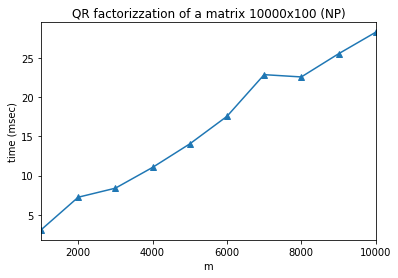

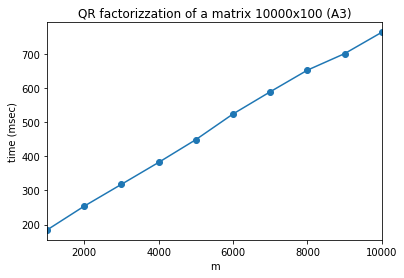

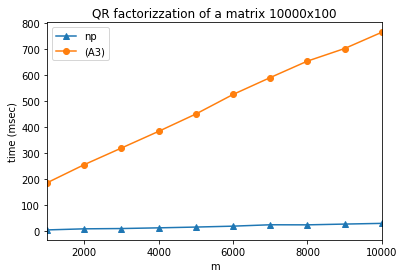

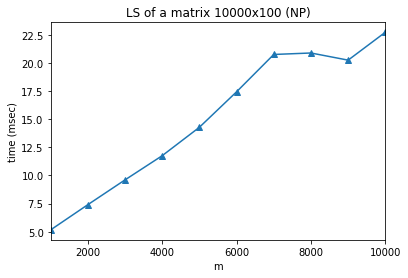

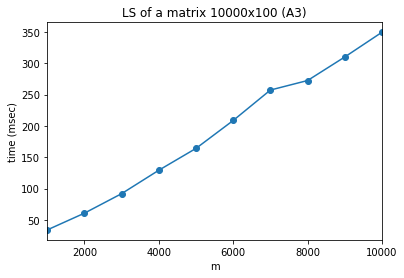

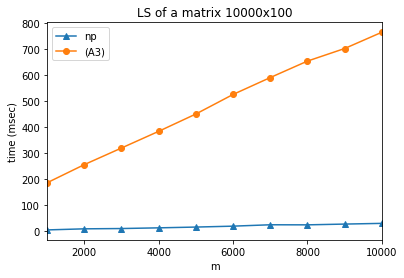

<Figure size 432x288 with 0 Axes>

In [20]:
starting_m = 1000
last_m = 11000
n = 100
step = 1000
repeat = 20
scaling(starting_m, last_m, n, step, repeat, save=False)

n=100, m=60000, t=5
m        QR A3      delta      QR np      delta      LS A3      delta      LS np      delta     
----------------------------------------------------------------------------------------------------
10000  || 729.2852 | 729.2852 |  30.8318 |  30.8318 | 351.2866 | 351.2866 |  21.6386 |  21.6386
20000  || 2499.1354 | 1769.8502 | 146.6556 | 115.8238 | 680.8914 | 329.6048 |  84.3134 |  62.6748
30000  || 3653.1586 | 1154.0232 | 334.8496 | 188.1940 | 999.3968 | 318.5054 | 189.3394 | 105.0260
40000  || 4763.1856 | 1110.0270 | 508.1834 | 173.3338 | 1316.6448 | 317.2480 | 273.7984 |  84.4590
50000  || 6091.2424 | 1328.0568 | 668.1722 | 159.9888 | 1742.0770 | 425.4322 | 371.9702 |  98.1718

m        residual A3              residual np              reconstruct a3           reconstruct np          
----------------------------------------------------------------------------------------------------
10000  ||     1.0041361347242301 |     0.9959369419579248 | 1.1480712413120302e-1

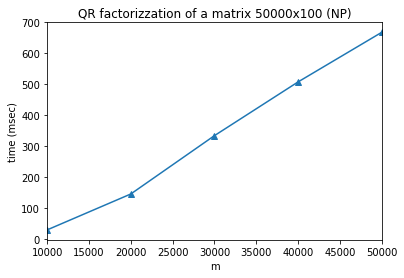

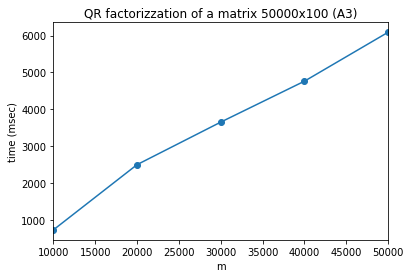

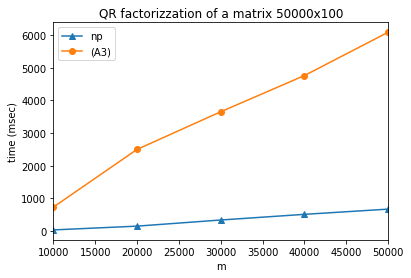

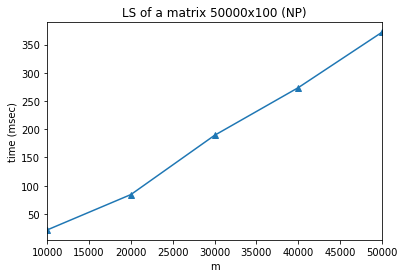

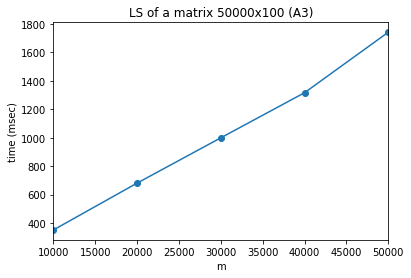

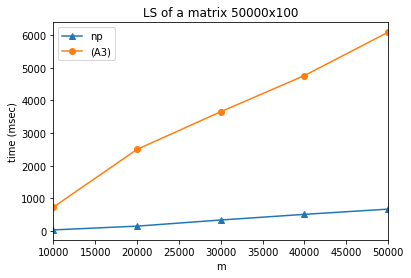

<Figure size 432x288 with 0 Axes>

In [6]:
starting_m = 10000
last_m = 60000
n = 100
step = 10000
repeat = 5
scaling(starting_m, last_m, n, step, repeat, save=False)

# CUP test

In [6]:
cup = '../../data/ML-CUP20-TR.csv'

In [7]:
M, M_test, b, b_test = load_CUP(cup, split=0)
res, resnp = automatized_test(M, b, 'CUP')
print(f"MSE A3: {mean_squared_error(np.matmul(M, res),b)}")
print(f"MSE np: {mean_squared_error(np.matmul(M, resnp),b)}\n\n")


A,b = generate(5000,50)
res, resnp = automatized_test(A, b, 'RANDOM')
print(f"MSE A3: {mean_squared_error(np.matmul(A, res),b)}")
print(f"MSE np: {mean_squared_error(np.matmul(A, resnp),b)}")

---------- CUP DATASET ----------
Solved (m x n): (1524,10) in 18.12 msec, w/ np in 1.048 msec     - Reverting and reconstruction: 11.472 msec, w/ np took: 2.42 msec
res error: 1.0537730959643323 - np_res error: 0.9962999753126451
QR error: 4.933387024233579e-16 - QR error w/ np: 3.2893174070752366e-16

2301.9828413363366
5299125.001806917
MSE A3: 972.4632084924591
MSE np: 869.279035729481


---------- RANDOM DATASET ----------
Solved (m x n): (5000,50) in 77.507 msec, w/ np in 11.632 msec     - Reverting and reconstruction: 224.401 msec, w/ np took: 24.152 msec
res error: 1.0046883682373453 - np_res error: 0.9953152817034856
QR error: 7.890140620708116e-16 - QR error w/ np: 3.9228035017837503e-16

69.64321288408017
4850.17710081731
MSE A3: 0.4941957441910004
MSE np: 0.485017710081731
